In [11]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string

In [12]:
#dir = './sequence/*'
dir = './datasets/seq/*'

In [13]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './datasets/seq/group'
for index in range(1, data_length+1):
    filename = file_predix + str(index) + "/*"
    print(filename)
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

./datasets/seq/group1/*
./datasets/seq/group2/*
./datasets/seq/group3/*
./datasets/seq/group4/*
./datasets/seq/group5/*
./datasets/seq/group6/*


In [14]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [15]:
train_name
tr_names= []
for name in train_name:
    tr_names.append(name.split('graph')[0])
    #tr_names.append(name.split('-')[0].replace('graph', ''))

In [16]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 500
steps_per_epoch = len(x_train)

In [17]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.categorical_crossentropy(y_true, y_pred)
    return loss1 * 0.7 + loss2 * 0.3

In [18]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 3))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(3))(decoded)
encoder = Model(inputs, encoded)

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(loss=custom_loss, optimizer='adam')#lr=1e-2, decay=0.9))
#lstm_autoencoder_500 = lstm_autoencoder

In [19]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [20]:
hist = lstm_autoencoder.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/200
4297/4297 [==============================] - 53s 12ms/step - loss: 266.0795 - val_loss: 137.4505
Epoch 2/200
4297/4297 [==============================] - 74s 17ms/step - loss: 146.4483 - val_loss: 125.8190
Epoch 3/200
4297/4297 [==============================] - 66s 15ms/step - loss: 128.9317 - val_loss: 106.1674
Epoch 4/200
4297/4297 [==============================] - 65s 15ms/step - loss: 103.1273 - val_loss: 84.7241
Epoch 5/200
4297/4297 [==============================] - 65s 15ms/step - loss: 90.5080 - val_loss: 71.9816
Epoch 6/200
4297/4297 [==============================] - 65s 15ms/step - loss: 72.4653 - val_loss: 63.7297
Epoch 7/200
4297/4297 [==============================] - 65s 15ms/step - loss: 60.7740 - val_loss: 49.9501
Epoch 8/200
4297/4297 [==============================] - 65s 15ms/step - loss: 55.7268 - val_loss: 45.0877
Epoch 9/200
4297/4297 [==============================] - 66s 15ms/step - loss: 44.8661 - val_loss: 38.9290
Epoch 10/200
4297/4297 [======

Epoch 77/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.4166 - val_loss: 14.8168
Epoch 78/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.4660 - val_loss: 13.4425
Epoch 79/200
4297/4297 [==============================] - 47s 11ms/step - loss: 14.0351 - val_loss: 13.9892
Epoch 80/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.6187 - val_loss: 13.2128
Epoch 81/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.2934 - val_loss: 13.5088
Epoch 82/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.2934 - val_loss: 14.1087
Epoch 83/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.5160 - val_loss: 13.6441
Epoch 84/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.5670 - val_loss: 13.6754
Epoch 85/200
4297/4297 [==============================] - 47s 11ms/step - loss: 12.0763 - val_loss: 12.9047
Epoch 86/200
4297/4297 [====

4297/4297 [==============================] - 47s 11ms/step - loss: 10.8928 - val_loss: 13.4894
Epoch 153/200
4297/4297 [==============================] - 47s 11ms/step - loss: 11.1345 - val_loss: 14.5736
Epoch 154/200
4297/4297 [==============================] - 47s 11ms/step - loss: 10.9850 - val_loss: 13.1713
Epoch 155/200
4297/4297 [==============================] - 47s 11ms/step - loss: 10.9420 - val_loss: 12.8553
Epoch 156/200
4297/4297 [==============================] - 47s 11ms/step - loss: 10.7290 - val_loss: 13.9231
Epoch 157/200
4297/4297 [==============================] - 47s 11ms/step - loss: 10.9419 - val_loss: 12.7377
Epoch 158/200
4297/4297 [==============================] - 47s 11ms/step - loss: 10.7534 - val_loss: 13.1787
Epoch 159/200
4297/4297 [==============================] - 47s 11ms/step - loss: 10.7084 - val_loss: 14.3604
Epoch 160/200
4297/4297 [==============================] - 47s 11ms/step - loss: 11.1297 - val_loss: 13.4566
Epoch 161/200
4297/4297 [========

In [21]:
import json
model_json = lstm_autoencoder.to_json()
filename = 'cce_model'  #input('filename: ') #
with open('models/' + filename + '.json', 'w') as file:
    file.write(model_json)
lstm_autoencoder.save_weights('models/weights_' +  filename + '.h5')

with open('models/cce_history.json', 'w') as f:
    json.dump(hist.history, f)

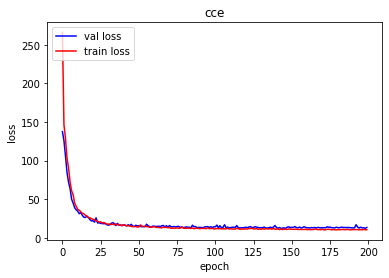

In [24]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.title('cce')
plt.show()

In [38]:
loaded_model = lstm_autoencoder

In [39]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = loaded_model.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

0.36404565399193833


In [19]:
filename = "last_mse_lstmae_cce"
loaded_model = model_from_json(open('res/cce/' +filename + '.json').read())
loaded_model.load_weights('model_save/mse_cce_models/weights_' + filename + '.h5')

In [ ]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [10]:
model_path = 'model_save/mse_cce_models/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min')#, period=5)